<font size = "12"> **MEASO space paper** </font>

# Loading relevant libraries

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, progress
import UsefulFunctions as uf
import os
import netCDF4 as nc
from collections import OrderedDict
from glob import glob
from clef.code import *
%matplotlib inline

# Setting up paralellisation prior to analysis

In [2]:
client = Client(n_workers = 8)

# Setting up dictionaries with supporting information for analysis

In [123]:
#This dictionary contains information about each variable to make production of summaries easier
#Change the values of this dictionary as needed
varDict = OrderedDict([
    ('temp', {'model': 'ACCESS-ESM1-5',
              'var_id': 'bigthetao',
              'exp': 'historical', 
              'exp_future': 'esm-ssp585',
              'variant': 'r10i1p1f1',
              'freq': 'mon',
              'long_name': 'water temperature', #Used mainly to label graphs
              'short_name': 'temp', #Used mainly to label graphs
              'means': r'/g/data/v45/la6889/MEASO/Summaries/Temperature/Means',
              'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/Temperature/Percentiles',
              'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/Temperature/StdDev'}),
    ('sal', {'model': 'ACCESS-ESM1-5',
             'var_id': 'so',
             'exp': 'historical', 
             'exp_future': 'esm-ssp585',
             'variant': 'r10i1p1f1',
             'freq': 'mon',
             'long_name': 'water salinity', 
             'short_name': 'sal', 
             'means': r'/g/data/v45/la6889/MEASO/Summaries/Salinity/Means',
             'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/Salinity/Percentiles',
             'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/Salinity/StdDev'}),
    ('chl',{'model': 'ACCESS-ESM1-5',
             'var_id': 'chl', #mass concentration of phytoplankton expressed as chl in sea water [kg m-3]
             'exp': 'historical', 
             'exp_future': 'esm-ssp585',
             'variant': 'r10i1p1f1',
             'freq': 'mon',
             'long_name': 'chlorophyll in sea water', 
             'short_name': 'chl', 
             'means': r'/g/data/v45/la6889/MEASO/Summaries/chl/Means',
             'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/chl/Percentiles',
             'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/chl/StdDev'}),
     ('pp',{'model': 'ACCESS-ESM1-5',
             'var_id': 'intpp', #primary organic C production by phytoplankton [mol m-2 s-1]
             'exp': 'historical', 
             'exp_future': 'esm-ssp585',
             'variant': 'r10i1p1f1',
             'freq': 'mon',
             'long_name': 'net primary productivity', 
             'short_name': 'netPP', 
             'means': r'/g/data/v45/la6889/MEASO/Summaries/netPP/Means',
             'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/netPP/Percentiles',
             'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/netPP/StdDev'}),
    ('pCO2',{'model': 'ACCESS-ESM1-5',
             'var_id': 'spco2', #Surface Aqueous Partial Pressure of CO2 [Pa] - only surface available
             'exp': 'historical', 
             'exp_future': 'esm-ssp585',
             'variant': 'r10i1p1f1',
             'freq': 'mon',
             'long_name': 'partial CO2 pressure at surface', 
             'short_name': 'pCO2', 
             'means': r'/g/data/v45/la6889/MEASO/Summaries/pCO2/Means',
             'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/pCO2/Percentiles',
             'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/pCO2/StdDev'}),
    ('mld', {'model': 'ACCESS-ESM1-5',
             'var_id': 'mlotst', #Ocean Mixed Layer Thickness Defined by Sigma T [m]
             'exp': 'historical', 
             'exp_future': 'esm-ssp585',
             'variant': 'r10i1p1f1',
             'freq': 'mon',
             'long_name': 'mixed layer depth', 
             'short_name': 'mld', 
             'means': r'/g/data/v45/la6889/MEASO/Summaries/MLD/Means',
             'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/MLD/Percentiles',
             'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/MLD/StdDev'}),
     ('sic', {'model': 'ACCESS-ESM1-5',
             'var_id': 'siconc', #sea ice area fraction (% of grid cell covered by ice)
             'exp': 'historical', 
             'exp_future': 'esm-ssp585',
             'variant': 'r10i1p1f1',
             'freq': 'mon',
             'long_name': 'sea ice concentration', 
             'short_name': 'sic', 
             'means': r'/g/data/v45/la6889/MEASO/Summaries/SIC/Means',
             'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/SIC/Percentiles',
             'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/SIC/StdDev'}),
    ('sw_rad', {'model': 'ACCESS-ESM1-5',
             'var_id': 'rsntds', #net downward shortwave radiation at sea water surface
             'exp': 'historical', 
             'exp_future': 'esm-ssp585',
             'variant': 'r10i1p1f1',
             'freq': 'mon',
             'long_name': 'net shortwave radiation', 
             'short_name': 'sw_rad', 
             'means': r'/g/data/v45/la6889/MEASO/Summaries/sw_rad/Means',
             'percentiles': r'/g/data/v45/la6889/MEASO/Summaries/sw_rad/Percentiles',
             'std_dev': r'/g/data/v45/la6889/MEASO/Summaries/sw_rad/StdDev'})
])

For some of the variables of interest, there are various options available in the ACCESS-ESM1.5 model, which are shown below. The items highlighted in **bold** are the variables used in this notebook.

sea ice concentration:
- siareas - sea ice area South (total area of sea ice in the Southern Hemisphere)
- siextents - sea ice extent South (total area of Southern Hemisphere cells covered by at least 15% areal fraction of sea ice)
- **siconc - sea ice area fraction (% of grid cell covered by ice)**
  
mixed layer depth:
- **mlotst - MLD defined by sigma T (potential density)**. Max and min mean daily values also available.
- omldamax - Ocean MLD defined by mixing scheme. Mean daily maximum

partial CO2 pressure:
- **spco2 - surface partial pressure of CO2 in sea water**

PAR:
- **rsntds - net downward shortwave flux at sea surface**

cloud cover:
- clhcalipso - Cloud area fraction in atmosphere later. % cloud cover in layer centered on 220hPa.

The following variables yield no results when searching ACCESS-ESM-1.5 outputs.  
ph:
- ~ph - sea water pH reported on total scale.~ This variables is available for CMIP5 models and earlier versions, not CMIP6.
- ~phnat - sea water pH natural analogue reported on total scale (Natural pH)~ Not available
- ~phabio - sea water pH abiotic analogue reported on total scale (Abiotic pH)~ Not available

In [124]:
var = 'sw_rad'

#This dictionary contains the time periods of interest
periods_interest = {'p1': np.arange(1890, 1911, 10),
                    'p2': np.arange(1940, 1961, 10),
                    'p3': np.arange(2000, 2021, 10),
                    'p4': np.arange(2040, 2061, 10),
                    'p5': np.arange(2090, 2101, 10)}

#This dictionary contains the depths of interest
depths_interest = {'surface': [0, 10],
                   'pelagic': [0, 200],
                   'krill': [0, 400]}

# Using clef to access ACCESS-ESM1.5 data
The function below, `searchACCESS`, uses the `clef` library from CLEX to search CMIP6 databases. The user can create a dictionary with search requirements to extract data that meets their needs.  
  
This function will be used to search data that would be used as weights in calculation of summary statistics per MEASO area. Variables that can be used as weights include area (`areacello`), depth (`thkcello`) and volume (`volcello`).  
  
More information about the `clef` library and how to use it can be found in [COECMS GitHub repository](https://github.com/coecms/clef).

## Accessing volume per pixel using the `clef` library

In [14]:
#Volume per pixel - For weighting
vol_file = uf.searchACCESS(var = 'volcello',
                        model = varDict[var]['model'], 
                        freq = 'fx', 
                        exp = varDict[var]['exp'], 
                        variant = varDict[var]['variant'])

In [222]:
#Loading volume data
vol_df = uf.loadData(filelist = vol_file, 
                      var_name = 'volcello',
                      SO = True, 
                      depth_range = [0, 401])

## Accessing area per pixel using the `clef` library

In [ ]:
area_file = uf.searchACCESS(var = 'areacello',
                        model = varDict[var]['model'], 
                        freq = 'fx', 
                        exp = varDict[var]['exp_future'], 
                        variant = varDict[var]['variant'])

In [ ]:
area_df = uf.loadData(filelist = area_file, 
                          var_name = 'areacello',
                          SO = True)

## Accessing depth per pixel using the `clef` library

In [5]:
depth_file = uf.searchACCESS(var = 'thkcello',
                        model = varDict[var]['model'], 
                        freq = 'fx', 
                        exp = varDict[var]['exp'], 
                        variant = varDict[var]['variant'])

In [7]:
depth_df = uf.loadData(filelist = depth_file, 
                          var_name = 'thkcello',
                          SO = True)

### Creating benthic mask

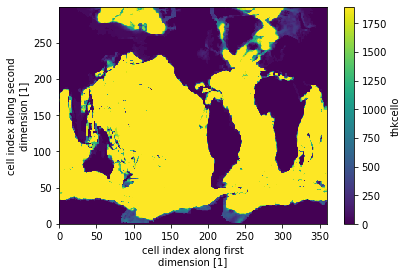

In [8]:
#Load depth data
depth = xr.open_dataset(depth_file[0], mask_and_scale = True)
#Extract levels shallower than 2000 meter deep
max_2000 = depth.thkcello[depth.lev_bnds[:,1] < 2000][...]
#Check mask up to 2000 m is correct
max_2000.sum('lev').plot()

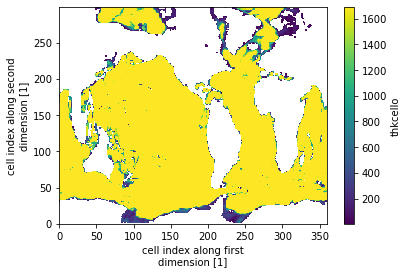

In [9]:
#Calculate bottom 200 meters from 2000 m mask
bottom_200 = max_2000.sum('lev')-200
#Set any negative values to NAs
bottom_200 = bottom_200.where(bottom_200 >= 0, np.nan)
#Check results
bottom_200.plot()

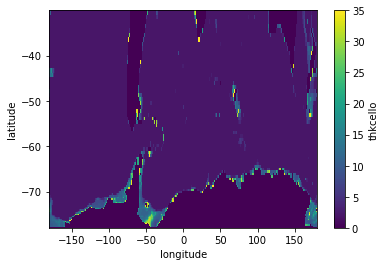

In [10]:
#Calculate cumulative depth
cum_depth = max_2000.cumsum(dim = 'lev')

#Create a mask using cumulative depth - Only keep values 
#deeper than bottom_200
mask_depth = xr.where(cum_depth >= bottom_200, 1, np.nan)
#Correct longitude values and subset SO
mask_depth = uf.corrlong(mask_depth).sel(latitude = slice(-90, -30))
mask_depth.sum('lev').plot()

# Using clef to extract ACCESS-ESM 1.5 data

## Finding datasets in `historical` experiment

In [125]:
#Create a session in CLEF to access CMIP6 data
db = connect()
s = Session()

#Define search parameters for CLEF
search_dict = {'variable_id': varDict[var]['var_id'], 
               'model': varDict[var]['model'],
               'frequency': varDict[var]['freq'], 
               'experiment_id': varDict[var]['exp'], 
               'variant_label': varDict[var]['variant']}

#Perform search
df = search(s, project = 'CMIP6', latest = True, **search_dict)
df

,project,activity_id,institution_id,source_id,source_type,experiment_id,sub_experiment_id,frequency,realm,variant_label,...,nominal_resolution,table_id,version,variable,path,filename,periods,fdate,tdate,time_complete
path,,,,,,,,,,,,,,,,,,,,,
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Omon/rsntds/gn/v20200605,CMIP6,CMIP,CSIRO,ACCESS-ESM1-5,AOGCM,historical,none,mon,ocean,r10i1p1f1,...,250 km,Omon,v20200605,rsntds,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACC...,{rsntds_Omon_ACCESS-ESM1-5_historical_r10i1p1f...,"[(18500101, 20141231)]",18500101,20141231,True


## Finding datasets in `SSP585` experiment

In [126]:
#Define search parameters for CLEF
search_dict = {'variable_id': varDict[var]['var_id'], 
               'model': varDict[var]['model'], 
               'frequency': varDict[var]['freq'], 
              'experiment_id': varDict[var]['exp_future'], 
               'variant_label': varDict[var]['variant']}

#Perform search
df_f = search(s, project = 'CMIP6', latest = True, **search_dict)
df_f

,project,activity_id,institution_id,source_id,source_type,experiment_id,sub_experiment_id,frequency,realm,variant_label,...,nominal_resolution,table_id,version,variable,path,filename,periods,fdate,tdate,time_complete
path,,,,,,,,,,,,,,,,,,,,,
/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-ssp585/r10i1p1f1/Omon/rsntds/gn/v20210316,CMIP6,C4MIP,CSIRO,ACCESS-ESM1-5,AOGCM BGC,esm-ssp585,none,mon,ocean,r10i1p1f1,...,250 km,Omon,v20210316,rsntds,/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/AC...,{rsntds_Omon_ACCESS-ESM1-5_esm-ssp585_r10i1p1f...,"[(20150101, 21001231)]",20150101,21001231,True


## Creating a single list of files for both experiments

In [127]:
#Get folder path where files are located
folder_path = df['path'][0]
folder_path_future = df_f['path'][0]

#Extract the file names inside the folders and sort them
filenames = sorted(glob(os.path.join(folder_path, '*.nc')))
filenames_future = sorted(glob(os.path.join(folder_path_future, '*.nc')))

#Join all file names under one variable
filenames = np.append(filenames, filenames_future)

#List filenames 
filenames

#Remove variables no longer in use
del folder_path, folder_path_future, filenames_future

## Separating lists into each period of interest

In [128]:
#Separate file list into each time period of interest
file_lists = {}

if len(filenames) > 2:
    #Loop over each period of interest
    for key in periods_interest:
        #Creating an empty list to hold file names
        files = []
        #Only keep filenames that are within the specified time period
        for fn in filenames:
            if (int(fn[-16:-12]) >= (periods_interest[key][0]-5)) \
            and (int(fn[-16:-12]) <= (periods_interest[key][-1])):
                #Add file names to dictionary
                files.append(fn)
        file_lists[key] = files
        #Remove list as it is no longer needed
        del files
else:
     for key in periods_interest:
        if periods_interest[key][0] < 2000:
            file_lists[key] = [filenames[0]]
        elif periods_interest[key][-1] == 2020:
            file_lists[key] = filenames
        else:
            file_lists[key] = [filenames[1]]

In [129]:
#Check list of files
file_lists

{'p1': ['/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Omon/rsntds/gn/v20200605/rsntds_Omon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc'],
 'p2': ['/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Omon/rsntds/gn/v20200605/rsntds_Omon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc'],
 'p3': array(['/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Omon/rsntds/gn/v20200605/rsntds_Omon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc',
        '/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-ssp585/r10i1p1f1/Omon/rsntds/gn/v20210316/rsntds_Omon_ACCESS-ESM1-5_esm-ssp585_r10i1p1f1_gn_201501-210012.nc'],
       dtype='<U170'),
 'p4': ['/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-ssp585/r10i1p1f1/Omon/rsntds/gn/v20210316/rsntds_Omon_ACCESS-ESM1-5_esm-ssp585_r10i1p1f1_gn_201501-210012.nc'],
 'p5': ['/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-

## Checking data structure prior to further processing (Optional step)

In [53]:
var = nc.Dataset(file_lists['p1'][0])
print(var)
print(var.__dict__)
[print(dim) for dim in var.dimensions.values()]
[print(var) for var in var.variables.values()]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: CMIP
    branch_method: standard
    branch_time_in_child: 0.0
    branch_time_in_parent: 87658.0
    creation_date: 2020-06-05T05:02:30Z
    data_specs_version: 01.00.30
    experiment: all-forcing simulation of the recent past
    experiment_id: historical
    external_variables: areacello volcello
    forcing_index: 1
    frequency: mon
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCESS-ESM1-5.historical.none.r10i1p1f1
    grid: native atmosphere N96 grid (145x192 latxlon)
    grid_label: gn
    history: 2020-06-05T05:02:30Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: Commonwealth Scientific and Industrial Research Organisation, Aspendale, Victoria 3195, Australia
    institution_id: CSIRO
    mip_era: CMIP6
    nominal_resolution: 250 km

[None, None, None, None, None, None, None, None, None, None, None]

# Creating a mask with regions of interest
Create a mask using a netcdf file with the `creatingMask` function. Masks can be created from shapefiles using the `0_CreatingMeasoMask.ipynb` notebook.

In [38]:
MEASOregions, regionNames = uf.creatingMask('MEASO_3Dmask.nc')

# Loading data for each period of interest

## Accessing data that will be used as weights
ACCESS-ESM-1.5 has the following variables that could be used as weights in summary calculations:
- area (`areacello`)
- depth (`thkcello`)
- volume (`volcello`)  
  
All the variables above provide data for each pixel in the area of interest.

## Calculating monthly stats

In [82]:
for per in periods_interest:
    years = [periods_interest[per][0], 
             periods_interest[per][-1]]
    
    # Loading variable of interest for each time period and depth of interest
    var_df = uf.loadData(filelist = file_lists[per], 
                      var_name = varDict[var]['var_id'],
                      SO = True, depth_range = [0, 2000],
                      years = years, 
                      months = ['07', '06'])

    #Selecting depth of interest
    if 'lev' in var_df.coords:
        mean_path_out = os.path.join(varDict[var]['means'], 'Benthic')
        os.makedirs(mean_path_out, exist_ok = True)
        file_out_m = os.path.join(mean_path_out,
                                  f'WeightedMonthlyMeans_2D_{var}_benthic_{years[0]}-{years[-1]}.nc')
        #Extract benthic data
        benthic_var = var_df[:,0:35].where(mask_depth == 1, np.nan)
        benthic_depth = depth_df[0:35].where(mask_depth == 1, np.nan)
        #Calculate weighted mean over depth
        weights = benthic_depth.fillna(0)
        mean_weighted = benthic_var.weighted(weights).mean('lev')
        mean_weighted.to_netcdf(file_out_m)
        for depth in depths_interest:
            #Creating paths to save data and ensuring they exist
            #Mean
            mean_path_out = os.path.join(varDict[var]['means'], depth.title())
            os.makedirs(mean_path_out, exist_ok = True)
            #Create filename
            file_out_m = os.path.join(mean_path_out, 
                                      f'WeightedMonthlyMeans_2D_{var}_{depth}_{years[0]}-{years[-1]}.nc')
            #Subsetting data to depth of interest
            var_sub = var_df.sel(lev = slice(depths_interest[depth][0],
                                             depths_interest[depth][-1]))
            depth_sub = depth_df.sel(lev = slice(depths_interest[depth][0],
                                             depths_interest[depth][-1]))
            #Calculate weighted mean over depth
            weights = depth_sub.fillna(0)
            mean_weighted = var_sub.weighted(weights).mean('lev')
            mean_weighted.to_netcdf(file_out_m)
    else:
        mean_path_out = varDict[var]['means']
        os.makedirs(mean_path_out, exist_ok = True)
        file_out_m = os.path.join(mean_path_out,
                                  f'MonthlyMeans_2D_{var}_{years[0]}-{years[-1]}.nc')
        var_df.to_netcdf(file_out_m)

## Calculating monthly stats for phytoplankton data

In [116]:
for per in periods_interest:
    years = [periods_interest[per][0], 
             periods_interest[per][-1]]
    
    # Loading variable of interest for each time period and depth of interest
    var_df = uf.loadData(filelist = file_lists[per], 
                      var_name = varDict[var]['var_id'],
                      SO = True, depth_range = [0, 2000],
                      years = years, 
                      months = ['07', '06'])
    var_df['latitude'] = np.round(var_df.latitude.values, 3)
    
    #Make sure output folder exists
    os.makedirs(varDict[var]['means'], exist_ok = True)
    #Create filename
    file_out_m = os.path.join(varDict[var]['means'],
                                  f'WeightedMonthlyMeans_2D_{var}_benthic_{years[0]}-{years[-1]}.nc')
    
    if 'lev' in var_df.coords:
        #Calculate weighted mean over depth
        weights = depth_df
        weights['latitude'] = np.round(weights.latitude.values, 3)
        weights = weights.fillna(0)
        mean_weighted = var_df.weighted(weights).mean('lev')
        mean_weighted.to_netcdf(file_out_m)
    else:
        var_df.to_netcdf(file_out_m)

## Calculating monthly stats for PAR based on shortwave radiation
Shortwave radiation (SW) in units of $Wm^{-2}$ are converted to PAR in units of $\mu mol m^{-2} s^{-1}$ using the conversion coefficient of `PAR = 2.114*SW`. This includes fraction of SW as PAR is an average of 0.46 and a conversion of ~4.57 from $Wm^{-2}$ to $\mu mol m^{-2} s^{-1}$. Reference [here](https://repository.oceanbestpractices.org/bitstream/handle/11329/1491/CSIRO_SOTS_PAR_2009-2019_QC_report_ver2.pdf?sequence=1&isAllowed=y).

In [134]:
for per in periods_interest:
    years = [periods_interest[per][0], 
             periods_interest[per][-1]]
    
    # Loading variable of interest for each time period and depth of interest
    var_df = uf.loadData(filelist = file_lists[per], 
                      var_name = varDict[var]['var_id'],
                      SO = True, depth_range = [0, 2000],
                      years = years, 
                      months = ['07', '06'])
    #Transforming shortwave into PAR
    var_df = var_df*2.114
    
    #Make sure output folder exists
    os.makedirs(varDict[var]['means'], exist_ok = True)
    #Create filename
    file_out_m = os.path.join(varDict[var]['means'],
                                  f'WeightedMonthlyMeans_2D_{var}_benthic_{years[0]}-{years[-1]}.nc')
    #Saving output
    var_df.to_netcdf(file_out_m)

## Applying functions to calculate summaries

In [ ]:
for per in periods_interest:
    years = [periods_interest[per][0], 
             periods_interest[per][-1]]
    
    # Loading variable of interest for each time period and depth of interest
    var_df = uf.loadData(filelist = file_lists[per], 
                      var_name = varDict[var]['var_id'],
                      SO = True, depth_range = [0, 401],
                      years = years, 
                      months = ['07', '06'])

    #Selecting depth of interest
    if 'lev' in var_df.coords:
        for depth in depths_interest:
            #Creating paths to save data and ensuring they exist
            #Mean
            mean_path_out = os.path.join(varDict[var]['means'], depth.title())
            os.makedirs(mean_path_out, exist_ok = True)
            #Create filename
            file_out_m = os.path.join(mean_path_out, 
                                      f'WeightedMonthlyMeans_{var}_{depth}_{years[0]}-{years[-1]}.nc')
            
            #Standard deviation
            std_path_out = os.path.join(varDict[var]['std_dev'], depth.title())
            os.makedirs(std_path_out, exist_ok = True)
            #Create filenames
            file_out_w = os.path.join(std_path_out, 
                                      f'WeightedMonthlyMeans_{var}_{depth}_{years[0]}-{years[-1]}.nc')
            file_out_u = os.path.join(std_path_out, 
                                      f'UnweightedMonthlyMeans_{var}_{depth}_{years[0]}-{years[-1]}.nc')
            
            #Percentiles
            per_path_out = os.path.join(varDict[var]['percentiles'], depth.title())
            os.makedirs(per_path_out, exist_ok = True)
            #Create filename
            file_out_p = os.path.join(per_path_out, 
                                    f'MonthlyPercentiles_{var}_{depth}_{years[0]}-{years[-1]}.nc')
            
            #Subsetting data to depth of interest
            var_sub = var_df.sel(lev = slice(depths_interest[depth][0],
                                             depths_interest[depth][-1]))
            vol_sub = vol_df.sel(lev = slice(depths_interest[depth][0],
                                             depths_interest[depth][-1]))
            
            #Summary statistics
            #Calculate weighted means
            weightedvarMeans = uf.weightedMeans(regions = regionNames, 
                                             var_df = var_sub, 
                                             mask_df =  MEASOregions, 
                                             weights = vol_sub)
            #Save file
            weightedvarMeans.to_netcdf(file_out_m)

            #Calculate weighted and unweighted standard deviation
            un_std_calcs, w_std_calcs = uf.std_dev(regions = regionNames,
                                                var_df = var_sub, 
                                                mask_df =  MEASOregions, 
                                                weights = vol_sub,
                                                weighted_means = weightedvarMeans)
            #Save file
            w_std_calcs.to_netcdf(file_out_w)
            un_std_calcs.to_netcdf(file_out_u)

            #Calculate percentiles
            per_calcs = uf.perc_calc(regions = regionNames,
                                  var_df = var_sub, 
                                  mask_df =  MEASOregions, 
                                  percentiles = [.2, .4, .5, .6, .8])
            #Save file
            per_calcs.to_netcdf(file_out_p)
    else:
        #Creating paths to save data and ensuring they exist
        #Mean
        mean_path_out = varDict[var]['means']
        os.makedirs(mean_path_out, exist_ok = True)
        #Create filename
        file_out_m = os.path.join(mean_path_out, 
                                f'WeightedMonthlyMeans_{var}_{years[0]}-{years[-1]}.nc')
        
        #Standard deviation
        std_path_out = varDict[var]['std_dev']
        os.makedirs(std_path_out, exist_ok = True)
        #Create filenames
        file_out_w = os.path.join(std_path_out, 
                                  f'WeightedMonthlyMeans_{var}_{years[0]}-{years[-1]}.nc')
        file_out_u = os.path.join(std_path_out, 
                                  f'UnweightedMonthlyMeans_{var}_{years[0]}-{years[-1]}.nc')
        
        #Percentiles
        per_path_out = varDict[var]['percentiles']
        os.makedirs(per_path_out, exist_ok = True)
        #Create filename
        file_out_p = os.path.join(per_path_out, 
                                f'MonthlyPercentiles_{var}_{years[0]}-{years[-1]}.nc')
        
        #No need to subset variable of interest data
        var_sub = var_df
        #Apply area per pixel instead of volume per pixel
        vol_sub = area_df
        
        #Summary statistics
        #Calculate weighted means
        weightedvarMeans = uf.weightedMeans(regions = regionNames, 
                                         var_df = var_sub, 
                                         mask_df =  MEASOregions, 
                                         weights = vol_sub)
        #Save file
        weightedvarMeans.to_netcdf(file_out_m)

        #Calculate weighted and unweighted standard deviation
        un_std_calcs, w_std_calcs = uf.std_dev(regions = regionNames,
                                            var_df = var_sub, 
                                            mask_df =  MEASOregions, 
                                            weights = vol_sub,
                                            weighted_means = weightedvarMeans)
        #Save file
        w_std_calcs.to_netcdf(file_out_w)
        un_std_calcs.to_netcdf(file_out_u)

        #Calculate percentiles
        per_calcs = uf.perc_calc(regions = regionNames,
                              var_df = var_sub, 
                              mask_df =  MEASOregions, 
                              percentiles = [.2, .4, .5, .6, .8])
        #Save file
        per_calcs.to_netcdf(file_out_p)

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  F

# Plotting results

In [108]:
# uf.loadData(filelist = var_int, 
#                           var_name = varDict[var]['var_id'],
#                           SO = True, depth_range = depths_interest[depth],
#                           years = years, 
#                           months = months)
var_name = varDict[var]['var_id']
x= []
if len(var_int) > 1:
    #Looping through files and stacking them
    for f in var_int:
        x.append(xr.open_dataset(f, mask_and_scale = True))
    #Concatenating files across time dimension
    x = xr.concat(x, dim = 'time')
else:
    x = xr.open_dataset(var_int[0], mask_and_scale = True)
    x = x[var_name][0]